<a href="https://colab.research.google.com/github/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Portfolio
*by Fabian Leuk (csba6437/12215478)*

## Session 5: Artifical Neural Networks

### Key Learnings

- How to create Multi-Layered Network Architectures using FastAI
- Deeper insights into the importance of loss functions as I revised the loss function in this portfolio for hours and hours
- Importance of randomized validation data sets
- More layers do not necessarily always perform better than a single layer
- When experimenting with convenience classes, always be careful how tensors are created. I had to squeeze a lot of results tensors unexpectedly.
- Visualize learning processes
- The use of DataLoader and DataLoaders




### Application: Predicting Titanic Mortality
I will apply the learnings to a dataset I retrieved from kaggle. (https://www.kaggle.com/competitions/titanic/overview) I will experiment with and use multi-layered neural networks.

The data analysis on this data set was already done in my last learning portfolio. (https://github.com/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_3.ipynb) I will reuse the previously defined data pipeline in this notebook and see if I get better results with different neural network architectures.


#### Data Import

In [1]:
import pandas as pd
from google.colab import drive
from google.colab import data_table
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
data_table.enable_dataframe_formatter()

drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/SE_Digital_Organizations/titanic_train.csv")

Mounted at /content/drive


In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *
drive.mount('/content/gdrive', force_remount=True)
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Data Preparation



In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def clip_to_1(x):
    return np.clip(x, a_min=None, a_max=1)

def log_transform(X):
    return np.log(X + 1)

log_pipeline = make_pipeline(
 FunctionTransformer(log_transform),
 MinMaxScaler(feature_range=(0, 1)))

age_pipeline = make_pipeline(
    KNNImputer(),
    log_pipeline
)

cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

embarked_pipeline = make_pipeline(SimpleImputer(strategy = "most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
 # drop unused columns Name, Cabin and Ticket
 ("drop_column", "drop", ["Name", "Cabin", "Ticket"]),
 # reducing to boolean variable for SibSp and Parch
 ("clip", FunctionTransformer(clip_to_1), ["SibSp", "Parch"]),
 # log and scaling for Fare
 ("log", log_pipeline, ["Fare"]),
 # imputation, log and scaling for Age
 ("impute_age", age_pipeline, ["Age"]),
 # one-hot-encoding for Pclass, Sex and Passenger Type
 ("cat", cat_pipeline, ["Pclass", "Sex", "Passenger Type"]),
 # imputation and one-hot-encoding for Embarked
 ("embarked", embarked_pipeline, ["Embarked"])
 ])



In [4]:
data = pd.read_csv("/content/gdrive/My Drive/SE_Digital_Organizations/titanic_train.csv")

# define function to apply to each row
def passenger_type(row):
    if row['Sex'] == 'female' and row['Age'] >= 18:
        return 0
    elif row['Age'] <= 18:
        return 1
    elif row['Sex'] == 'male' and row['Age'] >= 18:
        return 2
    else:
        return None

# apply function to create new column
data['Passenger Type'] = data.apply(passenger_type, axis=1)

data['Passenger Type'] = data.apply(passenger_type, axis=1)
data_label = data[["Survived"]].copy()
data = data.drop(["Survived"], axis=1)
data_prepared = preprocessing.fit_transform(data)

#### Single TLU




##### Training

This is our results from last weeks learning Portfolio using a single TLU.

In [5]:
tensor_data = torch.from_numpy(data_prepared)
tensor_label = torch.tensor(data_label.values).squeeze()

In [6]:
def f(x, params):
    a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q = params
    return sigmoid(a*x[:,0]+b*x[:,1]+c*x[:,2]+d*x[:,3]+e*x[:,4]+f*x[:,5]+g*x[:,6]+h*x[:,7]+i*x[:,8]+j*x[:,9]+k*x[:,10]+l*x[:,11]+m*x[:,12]+n*x[:,13]+o*x[:,14]+p*x[:,15]+q)

I define the root mean squared error as the loss function.

In [7]:
def rmse(preds, targets):

    squared_diff = torch.pow(preds - targets, 2)
    mean_squared_diff = torch.mean(squared_diff)
    rmse = torch.sqrt(mean_squared_diff)

    return rmse

Now let's train our TLU.

In [8]:
# Initializing learning rate
lr = 1e0

def apply_step(params):
    # Generating predictions based on input array x, current param set and function defined in f
    preds = f(tensor_data, params)
    # Calculating loss function for predictions and target values
    loss = rmse(preds, tensor_label)
    # Calculate gradient for current param set
    loss.backward()
    # Change param set according to learning rate and calculated gradients
    params.data -= lr * params.grad.data
    # Reset gradients for next iteration
    params.grad = None
    # print current loss
    return loss.item()

# Initializing parameters for prediction function to seventeen random values
params = torch.randn(17).requires_grad_()
prev_loss = 0
# repeat until local optimum is found
while True: 
  loss = apply_step(params)
  if loss == prev_loss:
    print("Local Optimum found.")
    break
  else:
    prev_loss = loss

Local Optimum found.


In [9]:
def accuracy(xb, yb):
  incorrect = ((yb.round() - xb).abs()).sum()
  return incorrect.item()/yb.shape[0]

preds = f(tensor_data, params)
accuracy(tensor_label, preds)

0.1829405162738496

18.3 percent of predictions are wrong using a single TLU

##### Testing

In [10]:
test_data = pd.read_csv("/content/gdrive/My Drive/SE_Digital_Organizations/titanic_test.csv")

test_data['Passenger Type'] = test_data.apply(passenger_type, axis=1)
test_data_prepared = preprocessing.fit_transform(test_data)
tensor_test_data = torch.from_numpy(test_data_prepared)

preds = f(tensor_test_data, params)
passengers = test_data["PassengerId"]

preds_df = pd.Series(preds.detach().round().int().numpy())

submission = pd.concat([passengers, preds_df], axis=1, keys=["PassengerId", "Survived"])

submission.to_csv(index=False)


'PassengerId,Survived\n892,0\n893,0\n894,0\n895,0\n896,0\n897,0\n898,1\n899,0\n900,1\n901,0\n902,0\n903,0\n904,1\n905,0\n906,1\n907,1\n908,0\n909,0\n910,0\n911,0\n912,0\n913,0\n914,1\n915,1\n916,1\n917,0\n918,1\n919,0\n920,0\n921,0\n922,0\n923,0\n924,0\n925,0\n926,0\n927,0\n928,0\n929,1\n930,0\n931,0\n932,0\n933,0\n934,0\n935,1\n936,1\n937,0\n938,0\n939,0\n940,1\n941,0\n942,0\n943,0\n944,1\n945,1\n946,0\n947,0\n948,0\n949,0\n950,0\n951,1\n952,0\n953,0\n954,0\n955,1\n956,1\n957,1\n958,1\n959,0\n960,0\n961,1\n962,1\n963,0\n964,0\n965,1\n966,1\n967,0\n968,0\n969,1\n970,0\n971,1\n972,0\n973,0\n974,0\n975,0\n976,0\n977,0\n978,1\n979,1\n980,1\n981,1\n982,1\n983,0\n984,1\n985,0\n986,1\n987,0\n988,1\n989,0\n990,1\n991,0\n992,1\n993,0\n994,0\n995,0\n996,0\n997,0\n998,0\n999,0\n1000,0\n1001,0\n1002,0\n1003,1\n1004,1\n1005,1\n1006,1\n1007,0\n1008,0\n1009,1\n1010,0\n1011,1\n1012,1\n1013,0\n1014,1\n1015,0\n1016,0\n1017,0\n1018,0\n1019,1\n1020,0\n1021,0\n1022,0\n1023,0\n1024,0\n1025,0\n1026,0\n1027,

On Kaggle, our single TLU scored 77.511 percent.

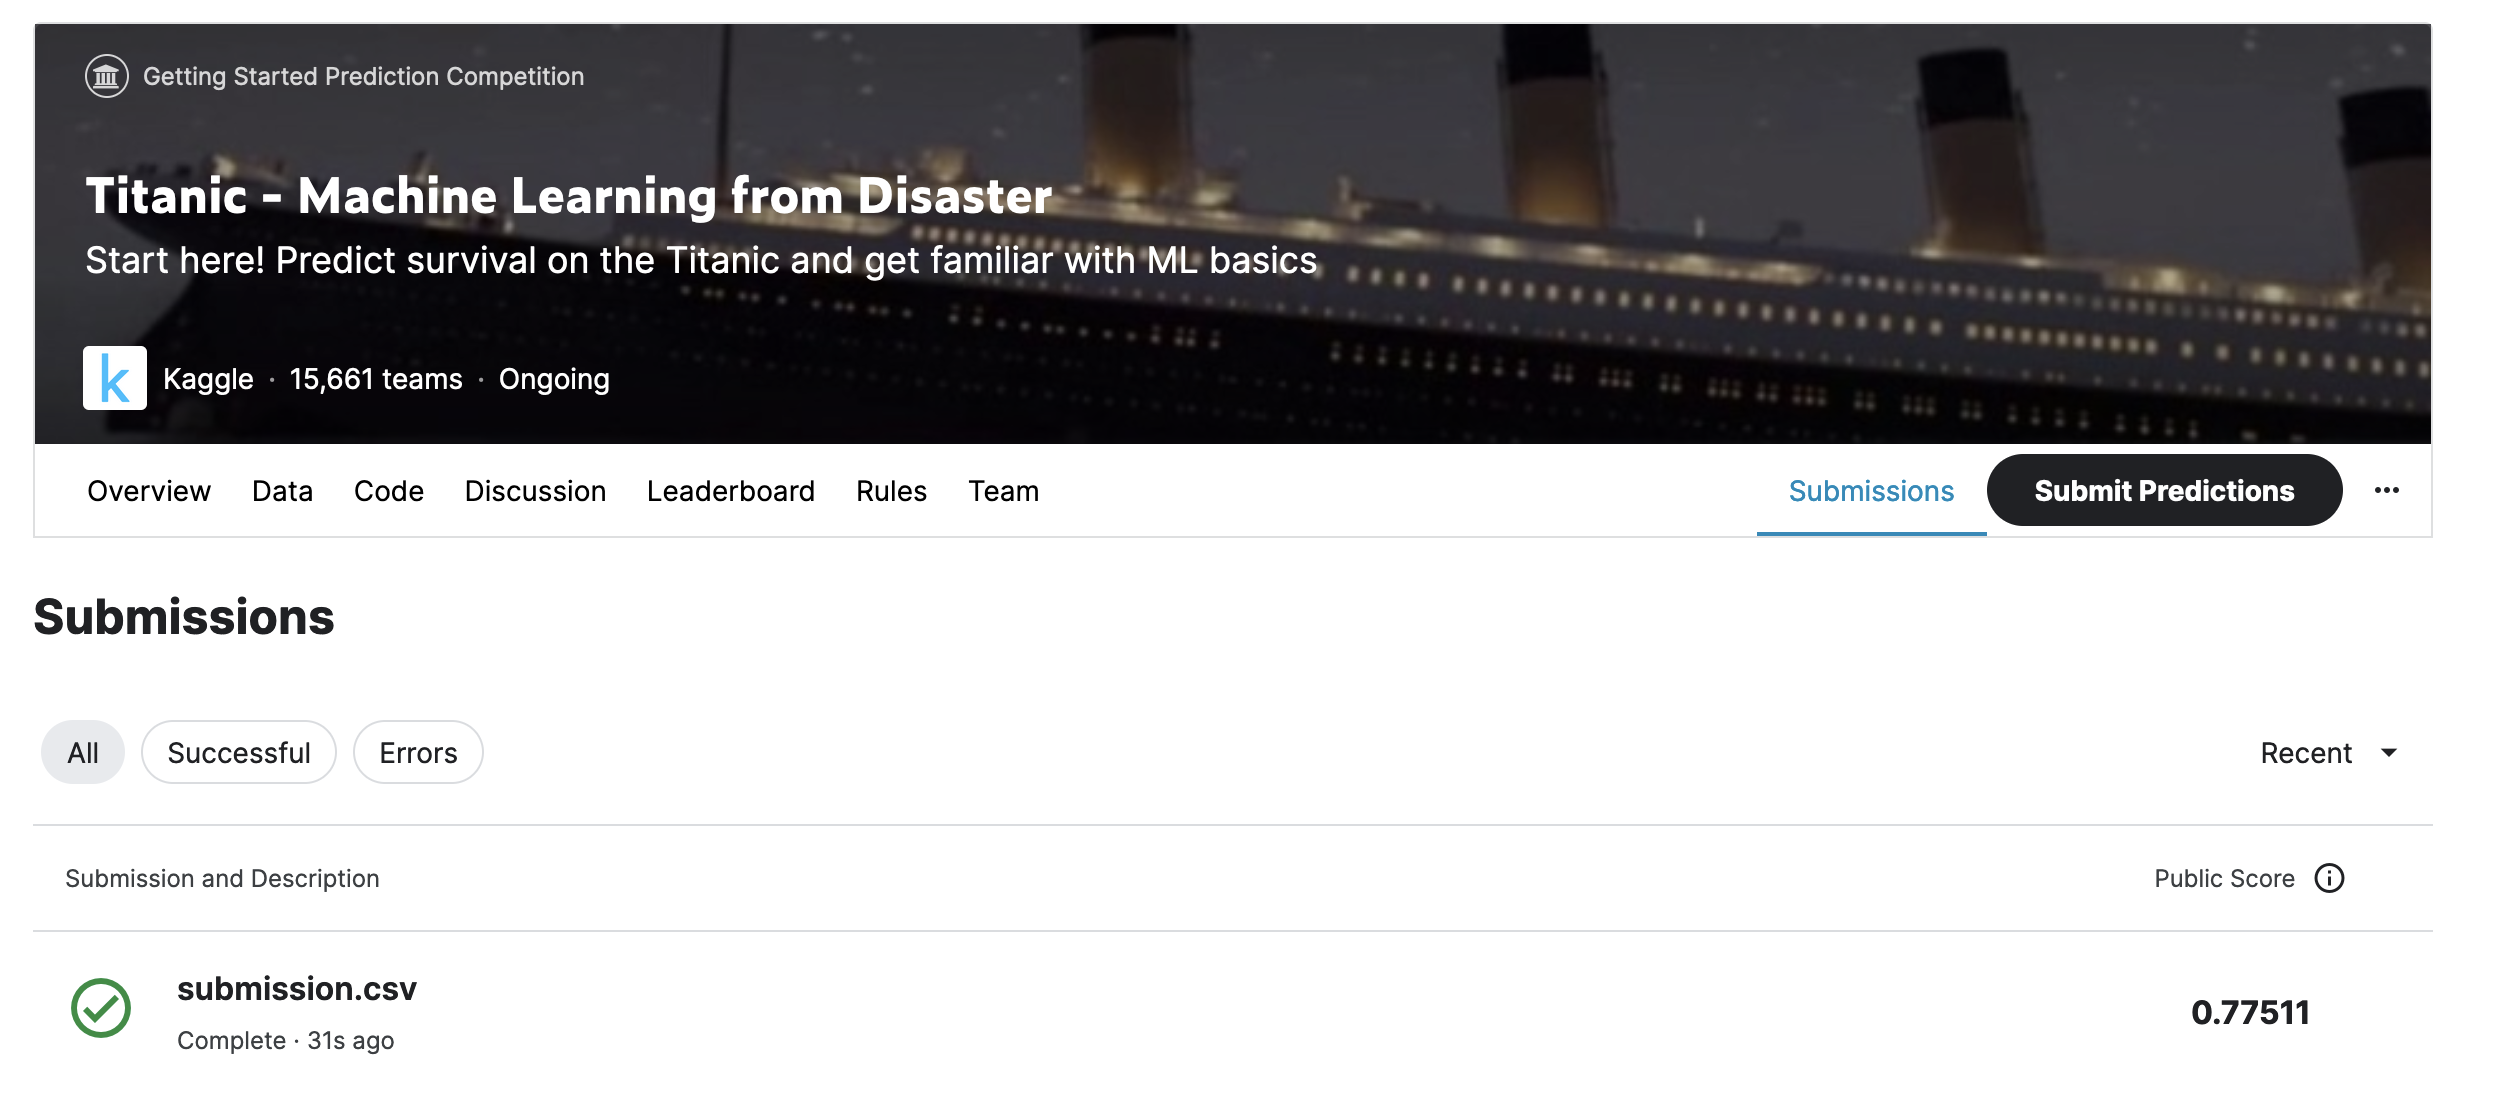

#### Multi-Layered Neural Network


##### Training

Let's try different neural network architectures and see which results we get.

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.502957,0.494521,0.640000,00:00
1,0.497026,0.484662,0.640000,00:00
2,0.492838,0.478453,0.640000,00:00
3,0.489576,0.473446,0.640000,00:00
4,0.486653,0.467989,0.640000,00:00
5,0.483565,0.460759,0.640000,00:00
6,0.479776,0.450334,0.640000,00:00
7,0.474659,0.434782,0.790000,00:00
8,0.467613,0.414186,0.790000,00:00
9,0.458693,0.394473,0.780000,00:00


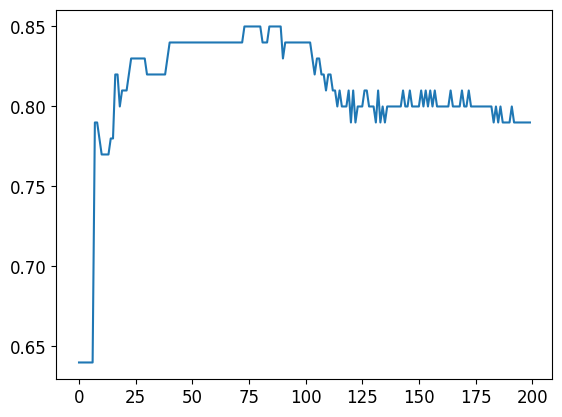

In [11]:
# Build the model: 16 -> 8 -> 3 -> Output
simple_net = nn.Sequential(
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Linear(8,3),
    nn.ReLU(),
    nn.Linear(3,1),
)

# Accuracy function
def batch_accuracy(xb, yb):
    xb = xb.sigmoid()
    xb = xb.squeeze()
    correct = (xb>0.5) == yb
    return correct.float().mean()

# Loss function: Root Mean Squared Error
def titanic_loss(predictions, targets):
    predictions = predictions.sigmoid()
    predictions=predictions.squeeze()
    squared_diff = torch.pow(predictions - targets, 2)
    mean_squared_diff = torch.mean(squared_diff)
    rmse = torch.sqrt(mean_squared_diff)

    return rmse

tensor_data = torch.from_numpy(data_prepared)
tensor_label = torch.tensor(data_label.values).squeeze()

tensor_data = tensor_data.float()
tensor_label = tensor_label.float()

# Splitting into training validation data. TO-DO: Randomize
tensor_data, valid_data = torch.split(tensor_data, [tensor_data.shape[0]-100, 100])
tensor_label, valid_label = torch.split(tensor_label, [tensor_label.shape[0]-100, 100])


# The data sets and data loaders for both training and validation.
dl = DataLoader(list(zip(tensor_data,tensor_label)), batch_size=100)
valid_dl = DataLoader(list(zip(valid_data,valid_label)), batch_size=10)
dls = DataLoaders(dl, valid_dl)

# Learner takes test and validation dataset, the model, the SGD for optimization, 
# the minst_loss function for calculating the loss, the batch_accuracy for validation
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=titanic_loss, metrics=batch_accuracy)
learn.fit(200, 0.4)
plt.plot(L(learn.recorder.values).itemgot(2));

Here, I experimented with different architectures. One of the best architectures for the accuracy with up to 88 percent was a three-layered network transform from 16 to 8 to 3 to Output. I also experimented with different learning rates and finally set it to 0.4.

##### Testing

In [12]:
test_data = pd.read_csv("/content/gdrive/My Drive/SE_Digital_Organizations/titanic_test.csv")

test_data['Passenger Type'] = test_data.apply(passenger_type, axis=1)
test_data_prepared = preprocessing.fit_transform(test_data)
tensor_test_data = torch.from_numpy(test_data_prepared)
tensor_test_data = tensor_test_data.float()

# create a DataLoader for test data
test_dl = DataLoader(tensor_test_data, batch_size=1)

# use the model to make predictions on the test data
preds = learn.get_preds(dl=test_dl)

# round the predictions to the nearest integer (0 or 1)
preds = torch.tensor(preds[0])
preds = torch.sigmoid(preds)
preds = torch.round(preds)
preds = preds.int()

# convert the predictions to a pandas DataFrame
preds_df = pd.DataFrame(preds.numpy(), columns=["Survived"])

passengers = test_data["PassengerId"]
submission = pd.concat([passengers, preds_df], axis=1)
submission.to_csv(index=False)

<ipython-input-12-dea1b6c01b94>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds[0])


'PassengerId,Survived\n892,0\n893,0\n894,0\n895,0\n896,0\n897,0\n898,0\n899,0\n900,0\n901,0\n902,0\n903,0\n904,1\n905,0\n906,1\n907,1\n908,0\n909,0\n910,0\n911,0\n912,0\n913,0\n914,1\n915,1\n916,1\n917,0\n918,1\n919,0\n920,0\n921,0\n922,0\n923,0\n924,0\n925,0\n926,1\n927,0\n928,0\n929,1\n930,0\n931,0\n932,0\n933,0\n934,0\n935,1\n936,1\n937,0\n938,1\n939,0\n940,1\n941,0\n942,1\n943,0\n944,1\n945,1\n946,0\n947,0\n948,0\n949,0\n950,0\n951,1\n952,0\n953,0\n954,0\n955,0\n956,1\n957,1\n958,0\n959,0\n960,1\n961,1\n962,0\n963,0\n964,0\n965,1\n966,1\n967,1\n968,0\n969,1\n970,0\n971,0\n972,1\n973,0\n974,0\n975,0\n976,1\n977,0\n978,0\n979,1\n980,1\n981,1\n982,0\n983,0\n984,1\n985,0\n986,1\n987,0\n988,1\n989,0\n990,1\n991,0\n992,1\n993,0\n994,0\n995,0\n996,1\n997,0\n998,0\n999,0\n1000,0\n1001,0\n1002,0\n1003,1\n1004,1\n1005,0\n1006,1\n1007,0\n1008,0\n1009,1\n1010,1\n1011,1\n1012,1\n1013,0\n1014,1\n1015,0\n1016,0\n1017,0\n1018,0\n1019,1\n1020,0\n1021,0\n1022,0\n1023,0\n1024,0\n1025,0\n1026,0\n1027,

I have submitted the results to Kaggle and unfortunately our multi-layered ANN performed a little bit worse. In our validation phase, we received results of up to 88 percent. The result may indicate overfitting our model to the training and validation data.

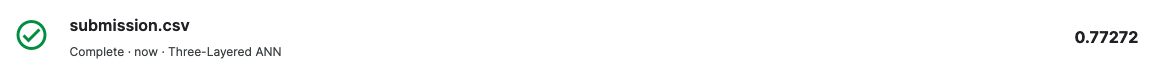